In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [3]:
PATH = "data/taxi/"

In [4]:
!ls {PATH}

test.csv  train.csv


In [5]:
df_raw = pd.read_csv(f'{PATH}train.csv', low_memory=False, 
                     parse_dates=["pickup_datetime","dropoff_datetime"])

In [6]:
df_raw.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [7]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [8]:
display_all(df_raw.describe(include='all').T)

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
id,1458644,1458644,id2081848,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vendor_id,1.45864e+06,NaN,NaN,NaN,NaN,NaN,1.53495,0.498777,1,1,2,2,2
pickup_datetime,1458644,1380222,2016-03-04 08:07:34,5,2016-01-01 00:00:17,2016-06-30 23:59:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dropoff_datetime,1458644,1380377,2016-05-16 19:40:28,5,2016-01-01 00:03:31,2016-07-01 23:02:03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
passenger_count,1.45864e+06,NaN,NaN,NaN,NaN,NaN,1.66453,1.31424,0,1,1,2,9
pickup_longitude,1.45864e+06,NaN,NaN,NaN,NaN,NaN,-73.9735,0.0709019,-121.933,-73.9919,-73.9817,-73.9673,-61.3355
pickup_latitude,1.45864e+06,NaN,NaN,NaN,NaN,NaN,40.7509,0.0328812,34.3597,40.7373,40.7541,40.7684,51.8811
dropoff_longitude,1.45864e+06,NaN,NaN,NaN,NaN,NaN,-73.9734,0.0706433,-121.933,-73.9913,-73.9798,-73.963,-61.3355
dropoff_latitude,1.45864e+06,NaN,NaN,NaN,NaN,NaN,40.7518,0.0358906,32.1811,40.7359,40.7545,40.7698,43.921
store_and_fwd_flag,1458644,2,N,1450599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df_raw.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


# Preprocessing

In [10]:
df_raw = pd.get_dummies(df_raw, columns=["store_and_fwd_flag"])

In [12]:
df_raw.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,store_and_fwd_flag_N,store_and_fwd_flag_Y
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,455,1,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,663,1,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,2124,1,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,429,1,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,435,1,0


In [14]:
from fastai.imports import *
from fastai.structured import *

In [15]:
add_datepart(df_raw, 'pickup_datetime')

In [16]:
display_all(df_raw.describe().T)

,count,mean,std,min,25%,50%,75%,max
vendor_id,1458644.0,1.534950e+00,4.987772e-01,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00
passenger_count,1458644.0,1.664530e+00,1.314242e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,9.000000e+00
pickup_longitude,1458644.0,-7.397349e+01,7.090186e-02,-1.219333e+02,-7.399187e+01,-7.398174e+01,-7.396733e+01,-6.133553e+01
pickup_latitude,1458644.0,4.075092e+01,3.288119e-02,3.435970e+01,4.073735e+01,4.075410e+01,4.076836e+01,5.188108e+01
dropoff_longitude,1458644.0,-7.397342e+01,7.064327e-02,-1.219333e+02,-7.399133e+01,-7.397975e+01,-7.396301e+01,-6.133553e+01
dropoff_latitude,1458644.0,4.075180e+01,3.589056e-02,3.218114e+01,4.073588e+01,4.075452e+01,4.076981e+01,4.392103e+01
trip_duration,1458644.0,9.594923e+02,5.237432e+03,1.000000e+00,3.970000e+02,6.620000e+02,1.075000e+03,3.526282e+06
store_and_fwd_flag_N,1458644.0,9.944846e-01,7.406066e-02,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
store_and_fwd_flag_Y,1458644.0,5.515396e-03,7.406066e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
pickup_datetimeYear,1458644.0,2.016000e+03,0.000000e+00,2.016000e+03,2.016000e+03,2.016000e+03,2.016000e+03,2.016000e+03


In [17]:
df_raw.head()

,id,vendor_id,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,store_and_fwd_flag_N,...,pickup_datetimeDay,pickup_datetimeDayofweek,pickup_datetimeDayofyear,pickup_datetimeIs_month_end,pickup_datetimeIs_month_start,pickup_datetimeIs_quarter_end,pickup_datetimeIs_quarter_start,pickup_datetimeIs_year_end,pickup_datetimeIs_year_start,pickup_datetimeElapsed
0,id2875421,2,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,455,1,...,14,0,74,False,False,False,False,False,False,1457976295
1,id2377394,1,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,663,1,...,12,6,164,False,False,False,False,False,False,1465692215
2,id3858529,2,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,2124,1,...,19,1,19,False,False,False,False,False,False,1453203324
3,id3504673,2,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,429,1,...,6,2,97,False,False,False,False,False,False,1459971151
4,id2181028,2,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,435,1,...,26,5,86,False,False,False,False,False,False,1458999055


# Baseline

In [20]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df_raw.drop(['trip_duration','dropoff_datetime', 'id'], axis=1), df_raw.trip_duration)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [21]:
m.score(df_raw.drop(['trip_duration','dropoff_datetime', 'id'], axis=1), df_raw.trip_duration)

0.67399185344628

In [23]:
from xgboost import XGBRegressor

In [24]:
xgb = XGBRegressor(n_jobs=-1)
xgb.fit(X = df_raw.drop(['trip_duration','dropoff_datetime', 'id'], axis=1), y = df_raw.trip_duration)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [25]:
xgb.score(df_raw.drop(['trip_duration','dropoff_datetime', 'id'], axis=1), df_raw.trip_duration)

0.029929133324063998

In [26]:
df_test = pd.read_csv(f'{PATH}test.csv', low_memory=False)

In [27]:
df_test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [30]:
add_datepart(df_test, 'pickup_datetime')
df_test = pd.get_dummies(df_test, columns=["store_and_fwd_flag"])

In [32]:
df_test.head()

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag_N,store_and_fwd_flag_Y,pickup_datetimeYear,...,pickup_datetimeDay,pickup_datetimeDayofweek,pickup_datetimeDayofyear,pickup_datetimeIs_month_end,pickup_datetimeIs_month_start,pickup_datetimeIs_quarter_end,pickup_datetimeIs_quarter_start,pickup_datetimeIs_year_end,pickup_datetimeIs_year_start,pickup_datetimeElapsed
0,id3004672,1,1,-73.988129,40.732029,-73.990173,40.756680,1,0,2016,...,30,3,182,True,False,True,False,False,False,1467331198
1,id3505355,1,1,-73.964203,40.679993,-73.959808,40.655403,1,0,2016,...,30,3,182,True,False,True,False,False,False,1467331193
2,id1217141,1,1,-73.997437,40.737583,-73.986160,40.729523,1,0,2016,...,30,3,182,True,False,True,False,False,False,1467331187
3,id2150126,2,1,-73.956070,40.771900,-73.986427,40.730469,1,0,2016,...,30,3,182,True,False,True,False,False,False,1467331181
4,id1598245,1,1,-73.970215,40.761475,-73.961510,40.755890,1,0,2016,...,30,3,182,True,False,True,False,False,False,1467331173


In [35]:
prediction = xgb.predict(df_test.drop([ 'id'], axis=1))

In [36]:
predictions = pd.DataFrame(prediction)

In [37]:
predictions['id'] = df_test['id']
predictions.to_csv("submission.csv", index=False)

In [38]:
predictions.head()

,0,id
0,838.130798,id3004672
1,759.210449,id3505355
2,683.610291,id1217141
3,1095.964722,id2150126
4,677.687073,id1598245


In [42]:
predictions = predictions.rename(index=str, columns={0: "trip_duration"})

In [43]:
columnsTitles=["id","trip_duration"]
predictions=predictions.reindex(columns=columnsTitles)

In [44]:
predictions.head()

,id,trip_duration
0,id3004672,838.130798
1,id3505355,759.210449
2,id1217141,683.610291
3,id2150126,1095.964722
4,id1598245,677.687073


In [47]:
predictions.to_csv(f"{PATH}submission.csv", index=False)

# Pre-processing

In [48]:
len(df_test)

625134

In [50]:
df = df_raw.drop("trip_duration", axis=1)

In [52]:
y = df_raw.trip_duration

In [69]:
y = np.log(y)

In [70]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()
n_valid = 625134  # same as Kaggle's test set size
n_trn = len(df_raw)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((833510, 23), (833510,), (625134, 23))

# New Base

In [71]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train.drop(['dropoff_datetime', 'id'], axis=1)), y_train), rmse(m.predict(X_valid.drop(['dropoff_datetime', 'id'], axis=1)), y_valid),
                m.score(X_train.drop(['dropoff_datetime', 'id'], axis=1), y_train), m.score(X_valid.drop(['dropoff_datetime', 'id'], axis=1), y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [72]:
X_train.head()

,id,vendor_id,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag_N,store_and_fwd_flag_Y,...,pickup_datetimeDay,pickup_datetimeDayofweek,pickup_datetimeDayofyear,pickup_datetimeIs_month_end,pickup_datetimeIs_month_start,pickup_datetimeIs_quarter_end,pickup_datetimeIs_quarter_start,pickup_datetimeIs_year_end,pickup_datetimeIs_year_start,pickup_datetimeElapsed
0,id2875421,2,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,1,0,...,14,0,74,False,False,False,False,False,False,1457976295
1,id2377394,1,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,1,0,...,12,6,164,False,False,False,False,False,False,1465692215
2,id3858529,2,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,1,0,...,19,1,19,False,False,False,False,False,False,1453203324
3,id3504673,2,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,1,0,...,6,2,97,False,False,False,False,False,False,1459971151
4,id2181028,2,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,1,0,...,26,5,86,False,False,False,False,False,False,1458999055


In [73]:
y_train.head()

0    6.120297
1    6.496775
2    7.661056
3    6.061457
4    6.075346
Name: trip_duration, dtype: float64

In [74]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train.drop(['dropoff_datetime', 'id'], axis=1), y_train)
print_score(m)

[0.2018336178112147, 0.4739774583247564, 0.9362124505948519, 0.6491824865050952]


Feature ranking:
1. feature 3 (0.242832)
2. feature 2 (0.229283)
3. feature 4 (0.218512)
4. feature 5 (0.185260)
5. feature 20 (0.029756)
6. feature 11 (0.026683)
7. feature 12 (0.020332)
8. feature 13 (0.013941)
9. feature 10 (0.010215)
10. feature 1 (0.010175)
11. feature 0 (0.006168)
12. feature 9 (0.003714)
13. feature 14 (0.000878)
14. feature 15 (0.000824)
15. feature 17 (0.000399)
16. feature 7 (0.000350)
17. feature 16 (0.000312)
18. feature 6 (0.000296)
19. feature 19 (0.000070)
20. feature 8 (0.000000)
21. feature 18 (0.000000)


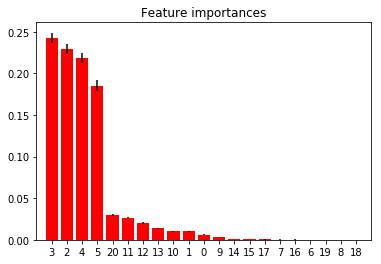

In [76]:
importances = m.feature_importances_
std = np.std([tree.feature_importances_ for tree in m.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.drop(['dropoff_datetime', 'id'], axis=1).shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.drop(['dropoff_datetime', 'id'], axis=1).shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.drop(['dropoff_datetime', 'id'], axis=1).shape[1]), indices)
plt.xlim([-1, X_train.drop(['dropoff_datetime', 'id'], axis=1).shape[1]])
plt.show()

In [78]:
X_train.drop(['dropoff_datetime', 'id'], axis=1).head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag_N,store_and_fwd_flag_Y,pickup_datetimeYear,pickup_datetimeMonth,...,pickup_datetimeDay,pickup_datetimeDayofweek,pickup_datetimeDayofyear,pickup_datetimeIs_month_end,pickup_datetimeIs_month_start,pickup_datetimeIs_quarter_end,pickup_datetimeIs_quarter_start,pickup_datetimeIs_year_end,pickup_datetimeIs_year_start,pickup_datetimeElapsed
0,2,1,-73.982155,40.767937,-73.964630,40.765602,1,0,2016,3,...,14,0,74,False,False,False,False,False,False,1457976295
1,1,1,-73.980415,40.738564,-73.999481,40.731152,1,0,2016,6,...,12,6,164,False,False,False,False,False,False,1465692215
2,2,1,-73.979027,40.763939,-74.005333,40.710087,1,0,2016,1,...,19,1,19,False,False,False,False,False,False,1453203324
3,2,1,-74.010040,40.719971,-74.012268,40.706718,1,0,2016,4,...,6,2,97,False,False,False,False,False,False,1459971151
4,2,1,-73.973053,40.793209,-73.972923,40.782520,1,0,2016,3,...,26,5,86,False,False,False,False,False,False,1458999055


In [79]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train.drop(['dropoff_datetime', 'id'], axis=1), y_train)
print_score(m)

[0.1841254728390016, 0.46145157682508925, 0.9469144088161949, 0.6674797033626856]


In [80]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train.drop(['dropoff_datetime', 'id'], axis=1), y_train)
print_score(m)

[0.17464680176222971, 0.45503151515898727, 0.9522393551459362, 0.6766678844774939]


In [81]:
m = RandomForestRegressor(n_estimators=100, n_jobs=-1)
m.fit(X_train.drop(['dropoff_datetime', 'id'], axis=1), y_train)
print_score(m)

[0.1687923736512722, 0.45079731423054326, 0.9553877066796737, 0.6826572868770896]


In [ ]:
m.predict